## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной (0 или 1, а НЕ вероятность) для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

In [4114]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report #, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [4115]:
df = pd.read_csv('course_project_train.csv')

In [4116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [4117]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [4118]:
def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()
    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [4119]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4120]:
def fill_missing_values(df):
    df['Annual Income'] = df['Annual Income'].fillna(df['Annual Income'].mean())
    df['Months since last delinquent'] = df['Months since last delinquent'].fillna(0)
    df['Bankruptcies'] = df['Bankruptcies'].fillna(0)
    df['Credit Score'] = df['Credit Score'].fillna(0)
    return df

In [4121]:
# попытка обработать совсем сильные выбросы
def process_anomalies(df):
    df['Years in current job'] = np.where(df['Years in current job'] == '< 1 year', 0, df['Years in current job'])
    df['Years in current job'] = df['Years in current job'].str.extract('(^\d*)').replace('', np.nan).fillna(0).astype(int)
    credit_coef = df['Credit Score'].mean() / df['Years of Credit History'].mean()
    df['Credit Score'] = np.where(df['Credit Score'] == 0,
                                  df['Years of Credit History'] * credit_coef - df['Bankruptcies'] * 100,
                                  df['Credit Score'])
    df['Credit Score'] = np.where(df['Credit Score'] > 3000, 0, df['Credit Score'])
    df['Maximum Open Credit'] = np.where(df['Maximum Open Credit'] > 3000000, 0, df['Maximum Open Credit'])
    return df

In [4122]:
def label_cats(df):
    le = LabelEncoder()
    for col in df:
        if df[col].dtype == 'object':
            if len(list(df[col].unique())) <= 15:
                le.fit(df[col])
                df[col] = le.transform(df[col])
    return df

In [4123]:
def scale_data(df, columns, weight):
    scaler = MinMaxScaler()
    df_norm = df.copy()
    df_norm[columns] = scaler.fit_transform(df_norm[columns])
    df = df_norm.copy()
    return df

In [4124]:
def get_poly_transformer(df, columns):
    poly_transformer = PolynomialFeatures(degree = 3)
    poly_transformer.fit(df[columns])
    return poly_transformer

In [4125]:
def add_poly_features(poly_transformer, df, columns):
    new_feautures = poly_transformer.transform(df[columns])
    new_feautures = pd.DataFrame(new_feautures, columns = poly_transformer.get_feature_names(columns))
    new_feautures.index = df.index
    new_df = df.merge(new_feautures, left_index=True, right_index=True)
    return new_df

In [4126]:
def prepare_dataset(data, base_columns, weight=1):
    data = fill_missing_values(data)
    data = process_anomalies(data)
    data = label_cats(data)
    data = scale_data(data, base_columns, weight)
    return data

In [4127]:
def plot_stats(feature,application_train,label_rotation=False,horizontal_layout=True):
    temp = application_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Количество займов': temp.values})
    # Расчет доли target=1 в категории
    cat_perc = application_train[[feature, TARGET_NAME]].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by=TARGET_NAME, ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Количество займов",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y=TARGET_NAME, order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Доля проблемных', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.show();

In [4128]:
def plot_kde(feature,app_train):
    sns.kdeplot(app_train.loc[app_train[TARGET_NAME] == 0, feature], label = 'target == 0')
    sns.kdeplot(app_train.loc[app_train[TARGET_NAME] == 1, feature], label = 'target == 1')
    plt.xlabel(feature); plt.ylabel('Density'); plt.title('Distribution');

In [4129]:
RANDOM_STATE=10
TARGET_NAME = 'Credit Default'
CAT_FEATURE_NAMES = ['Home Ownership', 'Purpose', 'Term']
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()

df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

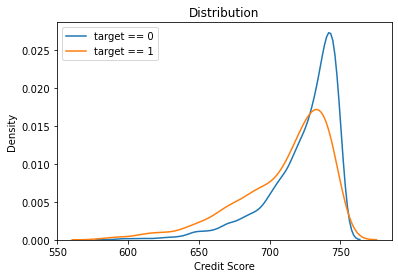

In [4130]:
# наиболее коррелирующий признак
plot_kde('Credit Score', df.loc[df['Credit Score'] < 3000, :])

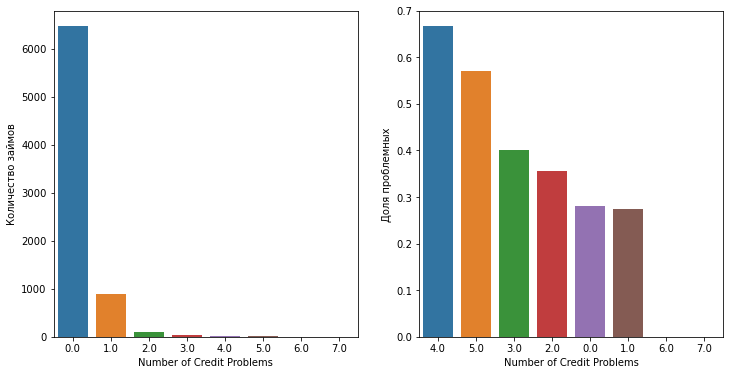

In [4131]:
plot_stats('Number of Credit Problems', df)

In [4132]:
# попытка синтеза новых признаков путем ручного объединения не удалась
# попытка создания новых признаков путем кластеризации не удалась
# осталась последняя попытка создания полиномиальных признаков
POLY_FEATURE_NAMES = ['Tax Liens', 'Number of Credit Problems', 'Bankruptcies',
                      'Credit Score', 'Maximum Open Credit']

In [4133]:
X = df.drop(columns=TARGET_NAME)
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=RANDOM_STATE)

In [4134]:
df_for_balancing = pd.concat([X_train, y_train], axis=1).copy()
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [4135]:
weight = 1
train = X_train.copy()
X_train = prepare_dataset(train, BASE_FEATURE_NAMES, weight)

poly_transformer = get_poly_transformer(X_train, POLY_FEATURE_NAMES)
X_train = add_poly_features(poly_transformer, X_train, POLY_FEATURE_NAMES)

In [4136]:
test = X_test.copy()
X_test = prepare_dataset(test, BASE_FEATURE_NAMES, weight)
X_test = add_poly_features(poly_transformer, X_test, POLY_FEATURE_NAMES)

In [4137]:
model_xgb = XGBClassifier(random_state=RANDOM_STATE, reg_alpha=2, reg_lambda=2)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.88      0.79      3795
           1       0.78      0.57      0.66      2910

    accuracy                           0.74      6705
   macro avg       0.75      0.72      0.73      6705
weighted avg       0.75      0.74      0.73      6705

TEST

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1592
           1       0.53      0.60      0.56       658

    accuracy                           0.72      2250
   macro avg       0.68      0.69      0.68      2250
weighted avg       0.74      0.72      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1235  357
1                262  396


In [4138]:
df_eval = pd.read_csv('course_project_test.csv')
df_eval.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [4139]:
df_eval = prepare_dataset(df_eval, BASE_FEATURE_NAMES, weight)
df_eval = add_poly_features(poly_transformer, df_eval, POLY_FEATURE_NAMES)
y_eval = model_xgb.predict(df_eval)

In [4140]:
df_eval[TARGET_NAME] = y_eval
df_eval[TARGET_NAME].to_csv('AZhumabayev_predictions.csv', index=False)